In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
x = np.linspace(0, 1, 100)
y = -x**2 - (1/3) * x + 2

plt.plot(x, y, linewidth=3)
plt.title('Přesné řešení úlohy: $u(x) = -x^2 - 1/3 x + 2$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)

plt.savefig('exact_solution_1d_heat.png')
plt.close()

# Řešení úlohy stacionárního 1D vedení tepla

V této úloze se pokusíme vyřešit úlohu
\begin{align*}
    -u''(x)&=2,\:\:x\in(0,1), \\
    u(0)&=2, \\
    2u(1)+u'(1)&=-1.
\end{align*}
pomocí jednoduché neuronové sítě s jednou skrytou vrstvou se dvěma neurony.

Tato úloha byla řešena analyticky a přené řešení je 
$$
    u(x) = -x^2 - \frac{1}{3} x + 2,\:\:x\in(0,1).
$$

![Přesné řešení úlohy](exact_solution_1d_heat.png)

Neuronová síť má následující vlastnosti:
- jeden vstupní neuron
- jedna skrytá vrstva se 2 neurony používajícími aktivační funkci Tanh
- jeden výstupní neuron

Proces definice, učení a vyhodnocování výkonnosti neuronové sítě je rozdělen do několika kroků:

**Krok 1:** Definujeme architekturu neuronové sítě, včetně jedné skryté vrstvy se 2 neurony a aktivační funkce Tanh. Vytvoříme také pomocnou funkci `compute_derivatives()`, která počítá první a druhé derivace s využitím utility `autograd.grad` z knihovny `PyTorch`.

**Krok 2:** Vygenerujeme 1000 tréninkových bodů z intervalu $ (0,1) $ a náhodná testovací data (díky znalosti přesného řešení).

**Krok 3:** Tréninková data převedeme do `DataLoader` pro učení v dávkách. Inicializujeme neuronovou síť a nastavíme optimalizátor Adam s mírou učení $10^{-2}$.

**Krok 4:** Spustíme smyčku pro učení na 2000 epoch. Během učení rozdělíme ztrátovou funkci na tři dílčí ztrátové funkce: pro diferenciální rovnici $-u''(x)=2$, pro Dirichletovu podmínku $u(0)=2$ a pro Robinovu podmínku $2u(1)+u'(1)=-1$. Minimalizujeme tedy jejich součet `total_loss`.

**Krok 5:** Vyhodnotíme model na testovacích datech a vypočteme relativní chybu a $R^2$ skóre mezi předpověďmi sítě a hodnotami funkce vypočtené analyticky.

**Krok 6:** Vykreslíme přesné řešení úlohy a porovnáme ji s aproximacemi provedenými neuronovou sítí po různých epochách učení. Dále graficky znázorníme hodnoty ztrátových funkcí v závislosti na počtu epoch. Vykraslíme také hodnoty relativní chyby a R2 skóre.

In [3]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        return x

In [4]:
# Krok 1.2: Funkce pro výpočet derivací pomocí funkce autograd z knihovny PyTorch
def compute_derivatives(model, x):
    x = x.requires_grad_(True)
    u = model(x)
    
    # u'(x)
    u_x = grad(u, x, torch.ones_like(u), create_graph=True)[0]
    
    # u''(x)
    u_xx = grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    return u, u_x, u_xx

In [5]:
# Krok 2.1: Vygenerování rovnoměrně rozložených trénovacích dat
x_train = torch.linspace(0, 1, 1000).reshape(-1, 1)
x_train.requires_grad = True

# Krok 2.2: Vygenerování náhodně rozložených testovacích dat
x_test = torch.rand(200, 1)
x_test_sorted, _ = torch.sort(x_test, dim=0)
x_test_sorted.requires_grad_(True)
u_exact = -x_test_sorted**2 - (1/3) * x_test_sorted+ 2 # Přesné řešení: u_ex = -x^2 - (1/3)x + 2

x_test_np = x_test_sorted.detach().numpy()
u_exact_numpy = u_exact.detach().numpy()

In [6]:
# Krok 3: Vytvoření DataLoaderu , inicializace modelu a optimalizátoru
batch_size = 64
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=1e-2) # Optimalizátor

In [7]:
# Krok 4: Smyčka pro učení neuronové sítě
pde_loss_values = [] # Seznam pro ukládání hodnot ztrátové funkce PDR
dirichlet_loss_values = [] # Seznam pro ukládání hodnot ztrátové funkce Dirichletovy podmínky
robin_loss_values = [] # Seznam pro ukládání hodnot ztrátové funkce Robinovy podmínky
relative_error_values = [] # Seznam pro ukládání relativních chyb modelu
r2_values = [] # Seznam pro ukládání R2 skóre modelu
epochs_to_save = [1, 5, 10, 30, 150, 1000, 2000]  # Epochy, které chceme vykreslit
approximations = [] # Seznam pro ukládání predikcí hodnot v daných epochách
num_epochs = 2000 # Počet epoch
# Smyčka pro učení neuronové sítě
for epoch in range(num_epochs):
    running_pde_loss = 0.0
    running_dirichlet_loss = 0.0
    running_robin_loss = 0.0

    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        
        u_pred, u_x_pred, u_xx_pred = compute_derivatives(model, x_batch) # Výpočet predikce NN a derivací

        pde_loss = torch.mean((u_xx_pred + 2)**2) # Ztráta PDR: l_pde = (u''(x) + 2)^2
        
        u_0 = model(torch.tensor([[0.0]]))
        dirichlet_loss = (u_0 - 2)**2 # Ztráta Dirichletovy podmínky: u(0) = 2
        
        u_1, u_x_1, _ = compute_derivatives(model, torch.tensor([[1.0]]))
        robin_loss = (2 * u_1 + u_x_1 + 1)**2 # Ztráta Robinovy podmínky: 2u(1) + u'(1) = -1

        total_loss = pde_loss + dirichlet_loss + robin_loss # Celková ztráta
 
        total_loss.backward() # Backward pass
        optimizer.step() # Optimalizace

        running_pde_loss += pde_loss.item()
        running_dirichlet_loss += dirichlet_loss.item()
        running_robin_loss += robin_loss.item()

    # Uložení průměrných ztrát pro tuto epochu
    avg_pde_loss = running_pde_loss / len(train_loader)
    avg_dirichlet_loss = running_dirichlet_loss / len(train_loader)
    avg_robin_loss = running_robin_loss / len(train_loader)
    
    pde_loss_values.append(avg_pde_loss)
    dirichlet_loss_values.append(avg_dirichlet_loss)
    robin_loss_values.append(avg_robin_loss)

    # Testování modelu pro následné vykreslení aproximací a chyb NN
    with torch.no_grad():
        model.eval()
        u_pred_test = model(x_test_sorted)
        
        # Relativní chyba
        numerator = torch.norm(u_pred_test - u_exact)
        denominator = torch.norm(u_exact)
        relative_error = (numerator / denominator).item()
        relative_error_values.append(relative_error)
        
        # R2 skóre
        u_exact_mean = torch.mean(u_exact)
        ss_res = torch.sum((u_pred_test - u_exact)**2)
        ss_tot = torch.sum((u_exact - u_exact_mean)**2)
        r2_score = 1 - (ss_res / ss_tot).item()
        r2_values.append(r2_score)

    # Predikce pro dané epochy
    if (epoch + 1) in epochs_to_save:
        approximations.append(u_pred_test.detach().numpy())
 
   # Výpis ztrát každých 100 epoch
    if (epoch + 1) % 100 == 0:
        print(f'Epocha [{epoch + 1}/{num_epochs}], Ztráta PDR: {avg_pde_loss:.6f}, Ztráta Dirichletovy podm.: {avg_dirichlet_loss:.6f}, Ztráta Robinovy podm.: {avg_robin_loss:.6f}')

# Vyhledání nejlepší epochy dle relativní chyby
min_value = min(relative_error_values)
min_index = relative_error_values.index(min_value)
print(f'Nejlepší epocha [{min_index+1}/{num_epochs}], Relativní chyba: {min_value:.4f}')

Epocha [100/2000], Ztráta PDR: 0.029344, Ztráta Dirichletovy podm.: 0.002625, Ztráta Robinovy podm.: 0.000708
Epocha [200/2000], Ztráta PDR: 0.030529, Ztráta Dirichletovy podm.: 0.002186, Ztráta Robinovy podm.: 0.000700
Epocha [300/2000], Ztráta PDR: 0.030388, Ztráta Dirichletovy podm.: 0.002047, Ztráta Robinovy podm.: 0.000975
Epocha [400/2000], Ztráta PDR: 0.029927, Ztráta Dirichletovy podm.: 0.002219, Ztráta Robinovy podm.: 0.000575
Epocha [500/2000], Ztráta PDR: 0.030994, Ztráta Dirichletovy podm.: 0.002123, Ztráta Robinovy podm.: 0.000653
Epocha [600/2000], Ztráta PDR: 0.031438, Ztráta Dirichletovy podm.: 0.001907, Ztráta Robinovy podm.: 0.000559
Epocha [700/2000], Ztráta PDR: 0.030944, Ztráta Dirichletovy podm.: 0.001941, Ztráta Robinovy podm.: 0.000893
Epocha [800/2000], Ztráta PDR: 0.030493, Ztráta Dirichletovy podm.: 0.001997, Ztráta Robinovy podm.: 0.000592
Epocha [900/2000], Ztráta PDR: 0.028858, Ztráta Dirichletovy podm.: 0.002884, Ztráta Robinovy podm.: 0.001819
Epocha [10

In [8]:
# Krok 5: Testovánín NN a výpočet chyby
total_test_loss_pde = 0.0
total_test_loss_dir = 0.0
total_test_loss_rob = 0.0
with torch.no_grad():
    model.eval()
    x_test_sorted.requires_grad_(True)
    
u_pred_test = model(x_test_sorted)  # Predikce NN

# Výpočet derivací
_, u_x_pred_test, u_xx_pred_test = compute_derivatives(model, x_test_sorted)

# Ztráta PDR
pde_loss_test = torch.mean((u_xx_pred_test + 2)**2)

# Ztráta Dirichletovy podmínky
u_0_test = model(torch.tensor([[0.0]], requires_grad=True))  # Ensure gradient tracking
dirichlet_loss_test = (u_0_test - 2)**2

# Ztráta Robinovy podmínky
u_1_test, u_x_1_test, _ = compute_derivatives(model, torch.tensor([[1.0]], requires_grad=True))
robin_loss_test = (2 * u_1_test + u_x_1_test + 1)**2

# Výpočet relativní chyby
numerator = torch.norm(u_pred_test - u_exact)
denominator = torch.norm(u_exact)
relative_error_test = (numerator / denominator).item()

# Výpočet R2 skóre
u_exact_mean = torch.mean(u_exact)
ss_res = torch.sum((u_pred_test - u_exact)**2)
ss_tot = torch.sum((u_exact - u_exact_mean)**2)
r2_score_test = 1 - (ss_res / ss_tot).item()

pde_loss_test = pde_loss_test.item()
dirichlet_loss_test = dirichlet_loss_test.item()
robin_loss_test = robin_loss_test.item()

# Výpis výsledků testování 
print(f'Výsledky testování:')
print(f'Konečná ztráta PDR: {pde_loss_test:.6f}')
print(f'Konečná ztráta Dirichletovy podmínky: {dirichlet_loss_test:.8f}')
print(f'Konečná ztráta Robinovy podmínky: {robin_loss_test:.6f}')
print(f'Relativní chyba: {relative_error_test:.6f}')
print(f'R2 skóre: {r2_score_test:.6f}')

Výsledky testování:
Konečná ztráta PDR: 0.020259
Konečná ztráta Dirichletovy podmínky: 0.00256986
Konečná ztráta Robinovy podmínky: 0.001573
Relativní chyba: 0.015374
R2 skóre: 0.996669


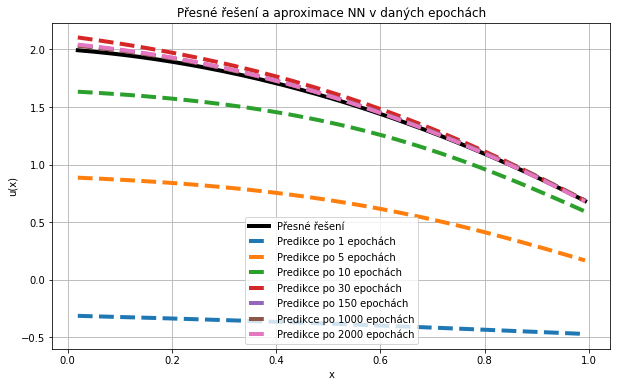

In [9]:
# Krok 6.1: Vykreslení přesného řešení a aproximací NN v daných epochách
plt.figure(figsize=(10, 6))
plt.plot(x_test_np, u_exact_numpy, label='Přesné řešení', color='black', linewidth=4)
for i, epoch in enumerate(epochs_to_save):
    plt.plot(x_test_np, approximations[i], label=f'Predikce po {epoch} epochách', linestyle='--', linewidth=4)
plt.title('Přesné řešení a aproximace NN v daných epochách')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

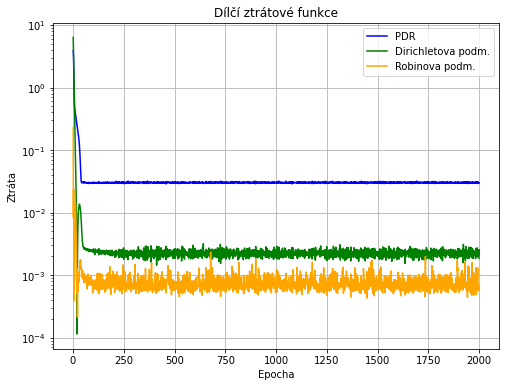

In [10]:
# Krok 6.2: Graf dílčích ztrát v závislosti na počtu provedených epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), pde_loss_values, label='PDR', color='blue')
plt.plot(range(1, num_epochs + 1), dirichlet_loss_values, label='Dirichletova podm.', color='green')
plt.plot(range(1, num_epochs + 1), robin_loss_values, label='Robinova podm.', color='orange')
plt.yscale('log')
plt.title('Dílčí ztrátové funkce')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.legend()
plt.grid(True)
plt.show()

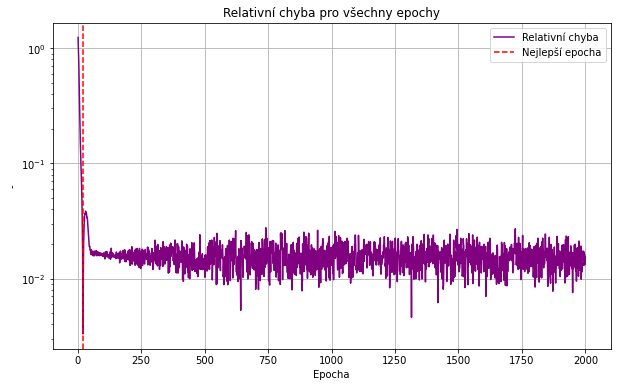

In [11]:
# Krok 6.3: Graf relativní chyby ve všech epochách
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), relative_error_values, label='Relativní chyba', color='purple')
plt.axvline(min_index, color='r', linestyle='--', label='Nejlepší epocha')
plt.title('Relativní chyba pro všechny epochy')
plt.yscale('log')
plt.xlabel('Epocha')
plt.ylabel('-')
plt.legend()
plt.grid(True)
plt.show()

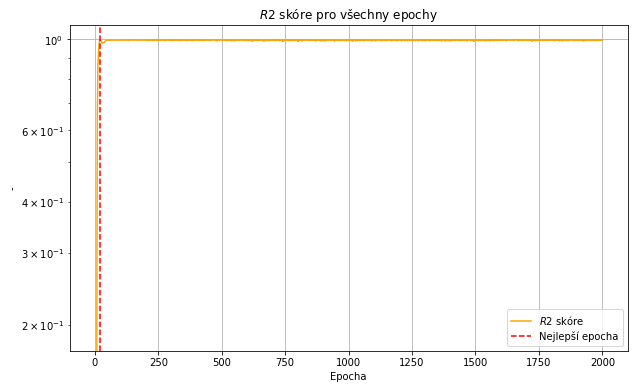

Epocha	R2 skóre
1	-20.6924095154
10	0.6664821804
20	0.9998456048
60	0.9957881747
300	0.9971214258
1000	0.9975993484
20	0.9998456048
2000	0.9966687488


In [12]:
# Krok 6.4: Vykreslení a výpis R2 skóre
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), r2_values, label='$R2$ skóre', color='orange')
plt.axvline(min_index, color='r', linestyle='--', label='Nejlepší epocha')
plt.title('$R2$ skóre pro všechny epochy')
plt.yscale('log')
plt.xlabel('Epocha')
plt.ylabel('-')
plt.legend()
plt.grid(True)
plt.show()

print(f'Epocha\tR2 skóre')
# Výpis hodnoty R2 skóre pro vybrané epochy
for i in  [1, 10, 20, 60, 300, 1000, min_index+1, 2000]:
    print(f'{i}\t{r2_values[i-1]:.10f}')